In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


from tqdm import tqdm
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 


from tensorflow.keras.utils import to_categorical
from tensorflow import set_random_seed
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv("data/Musical_instruments_reviews.csv")

In [5]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [6]:
data.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [7]:
data.shape

(10261, 9)

In [8]:
data["reviewText"].fillna("",inplace = True)

In [9]:
data.drop(columns = ['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime'],inplace = True)

In [10]:
data.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


In [11]:
data['review'] = data['reviewText'] + ' ' + data['summary']
data.drop(columns = ['reviewText','summary'],inplace = True)

In [12]:
data.head()

,overall,review
0,5.0,"Not much to write about here, but it does exac..."
1,5.0,The product does exactly as it should and is q...
2,5.0,The primary job of this device is to block the...
3,5.0,Nice windscreen protects my MXL mic and preven...
4,5.0,This pop filter is great. It looks and perform...


In [13]:
data.overall.value_counts().reset_index()

,index,overall
0,5.0,6938
1,4.0,2084
2,3.0,772
3,2.0,250
4,1.0,217


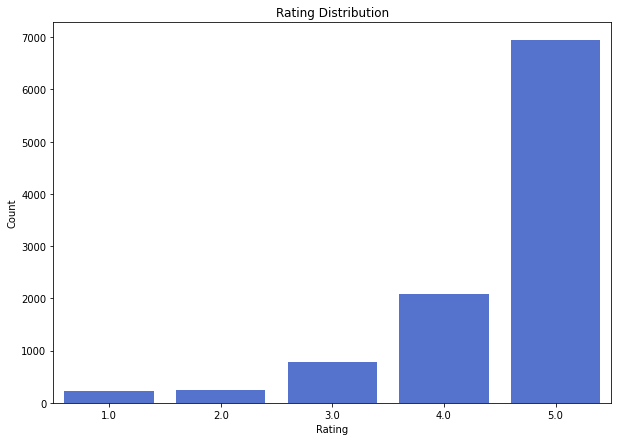

In [14]:
plt.figure(figsize=(10,7))
sns.barplot(x="index",y = "overall",data = data.overall.value_counts().reset_index(),color ="royalblue")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [15]:
# Replacing ratings of 1,2,3 with 0 (not good) and 4,5 with 1 (good)
data["overall"] = (data["overall"]>3)*1

In [16]:
X_train, X_test, y_train ,y_test = train_test_split(data.review, data.overall, test_size = 0.2 , random_state = 42)

In [17]:
def clean_sentences(X):
    reviews = []

    for sent in tqdm(X):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [18]:
train_sentences = clean_sentences(X_train)
test_sentences = clean_sentences(X_test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 2053/2053 [00:01<00:00, 1243.23it/s]

8208
2053


In [19]:
unique_words = set()
len_max = 0

for sent in tqdm(train_sentences):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 8208/8208 [00:00<00:00, 314929.63it/s]

15657
2067


In [20]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))


X_train = tokenizer.texts_to_sequences(train_sentences)
X_test = tokenizer.texts_to_sequences(test_sentences)

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_test.shape)

(8208, 2067) (2053, 2067)


In [48]:
mnb_model=MultinomialNB()

mnb_model = mnb_model.fit(X_train, y_train)

mnb_pred = mnb_model.predict(X_test)

score = accuracy_score(y_test, mnb_pred)

print("Score: ", score)

Score:  0.8041889917194349


In [49]:
mnb_bow_report = classification_report(y_test, mnb_model.predict(X_test))
print(mnb_bow_report)

              precision    recall  f1-score   support

           0       0.16      0.15      0.15       244
           1       0.89      0.89      0.89      1809

    accuracy                           0.80      2053
   macro avg       0.52      0.52      0.52      2053
weighted avg       0.80      0.80      0.80      2053



In [50]:
roc_auc_score(y_test,mnb_pred)

0.5201497068392101

In [51]:
lr = LogisticRegression(penalty='l2',max_iter=1000,C=1,random_state=0,class_weight="balanced")
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

score=accuracy_score(y_test, lr_pred)

print("Score: ", score)

Score:  0.5168046760837798


/home/eduard/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [52]:
lr_report = classification_report(y_test, lr_pred)
print(lr_report)

              precision    recall  f1-score   support

           0       0.12      0.51      0.20       244
           1       0.89      0.52      0.65      1809

    accuracy                           0.52      2053
   macro avg       0.51      0.51      0.43      2053
weighted avg       0.80      0.52      0.60      2053



In [53]:
roc_auc_score(y_test,lr_pred)

0.513081224116213

In [54]:
xgb = XGBClassifier( n_estimators=1000,max_depth=4,min_child_weight = 1 ,gamma = 0 ,
                    subsample = 0.8, class_weigh ="balanced", colsample_bytree = 0.8, nthread=6,seed= 9,tree_method='gpu_hist', gpu_id=0)

xgb.fit(X_train, y_train)
xgb_predict = xgb.predict(X_test)


In [64]:
accuracy_score(y_test, xgb_predict)

0.8835849975645397

In [55]:
xg_report = classification_report(y_test, xgb_predict)
print(xg_report)

              precision    recall  f1-score   support

           0       0.73      0.03      0.06       244
           1       0.88      1.00      0.94      1809

    accuracy                           0.88      2053
   macro avg       0.81      0.52      0.50      2053
weighted avg       0.87      0.88      0.83      2053



In [56]:
roc_auc_score(y_test,xgb_predict)

0.5155642552265993

In [60]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2067, 300)         4697100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 2067, 128)         219648    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 4,972,757
Trainable params: 4,972,757
Non-trainable params: 0
____________________________________________

In [61]:
model.fit(X_train, y_train,epochs=4, batch_size=256, verbose=1)

Epoch 1/4
8208/8208 [==============================] - 197s 24ms/sample - loss: 0.3719 - acc: 0.8690
Epoch 2/4
8208/8208 [==============================] - 196s 24ms/sample - loss: 0.2376 - acc: 0.9051
Epoch 3/4
8208/8208 [==============================] - 197s 24ms/sample - loss: 0.1780 - acc: 0.9326
Epoch 4/4
8208/8208 [==============================] - 197s 24ms/sample - loss: 0.1329 - acc: 0.9520


In [62]:
model.evaluate(X_test,y_test)[1]

2053/2053 [==============================] - 23s 11ms/sample - loss: 0.3735 - acc: 0.8685


0.86848515

In [44]:
nn_report = classification_report(y_test,model.predict(X_test)>0.5)
print(nn_report)

              precision    recall  f1-score   support

           0       0.55      0.38      0.45       244
           1       0.92      0.96      0.94      1809

    accuracy                           0.89      2053
   macro avg       0.73      0.67      0.69      2053
weighted avg       0.88      0.89      0.88      2053



In [63]:
roc_auc_score(y_test,model.predict(X_test)>0.5)

0.719730128954499

In [42]:
svc = LinearSVC(random_state=7,C=1,class_weight="balanced")

In [43]:
svc.fit(X_train,y_train)

/home/eduard/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, class_weight='balanced', random_state=7)

In [44]:
svc_predict = svc.predict(X_test)

In [57]:
accuracy_score(y_test, svc_predict)

0.7900633219678519

In [45]:
svc_report = classification_report(y_test, svc_predict)
print(svc_report)

              precision    recall  f1-score   support

           0       0.14      0.16      0.15       244
           1       0.88      0.88      0.88      1809

    accuracy                           0.79      2053
   macro avg       0.51      0.52      0.52      2053
weighted avg       0.80      0.79      0.79      2053



In [46]:
roc_auc_score(y_test,svc_predict)

0.5156797977326482